In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
import umap
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from pytorch_metric_learning import losses

In [2]:
# Set global parameters
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
print(device)

mps


In [42]:
class SubsetRandomSampler(torch.utils.data.sampler.Sampler):

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

In [49]:
from torch.utils.data import WeightedRandomSampler


# Load and preprocess CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define the size for the train and validation splits
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the training dataset into training and validation sets
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Calculate the class weights
class_counts = [0] * 10  # Assuming 10 classes in CIFAR10
for _, label in train_dataset:
    class_counts[label] += 1

total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]

# Create a list of sample weights based on class weights
sample_weights = [class_weights[label] for _, label in train_dataset]

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

# Create data loaders for training, validation, and test
train_loader = DataLoader(train_dataset, batch_size=128, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
# Check class distribution in each batch
num_classes = 10  # Assuming 10 classes in CIFAR10
batch_class_counts = [0] * num_classes

for batch_images, batch_labels in train_loader:
    for label in batch_labels:
        batch_class_counts[label] += 1

    # Print class counts for the current batch
    print("Class counts in the current batch:")
    for i, count in enumerate(batch_class_counts):
        print(f"Class {i}: {count}")

    # Reset batch class counts for the next batch
    batch_class_counts = [0] * num_classes

# Print overall class distribution in the training dataset
print("\nOverall class distribution in the training dataset:")
for i, count in enumerate(class_counts):
    print(f"Class {i}: {count}")

Class counts in the current batch:
Class 0: 14
Class 1: 16
Class 2: 16
Class 3: 13
Class 4: 10
Class 5: 15
Class 6: 16
Class 7: 17
Class 8: 9
Class 9: 2
Class counts in the current batch:
Class 0: 13
Class 1: 8
Class 2: 13
Class 3: 13
Class 4: 10
Class 5: 16
Class 6: 12
Class 7: 6
Class 8: 19
Class 9: 18
Class counts in the current batch:
Class 0: 9
Class 1: 16
Class 2: 9
Class 3: 13
Class 4: 17
Class 5: 13
Class 6: 18
Class 7: 17
Class 8: 11
Class 9: 5
Class counts in the current batch:
Class 0: 20
Class 1: 19
Class 2: 11
Class 3: 9
Class 4: 9
Class 5: 14
Class 6: 11
Class 7: 11
Class 8: 16
Class 9: 8
Class counts in the current batch:
Class 0: 16
Class 1: 9
Class 2: 15
Class 3: 17
Class 4: 6
Class 5: 11
Class 6: 13
Class 7: 15
Class 8: 18
Class 9: 8
Class counts in the current batch:
Class 0: 10
Class 1: 8
Class 2: 15
Class 3: 15
Class 4: 17
Class 5: 14
Class 6: 13
Class 7: 7
Class 8: 16
Class 9: 13
Class counts in the current batch:
Class 0: 20
Class 1: 16
Class 2: 18
Class 3: 13
Cl

## Help functions

### Training function

In [47]:
# Training function with validation and accuracy
def train(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate average losses and accuracies
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total
        
        # Append to lists
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        # Print training and validation loss and accuracy
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    
    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, marker='s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()
    
    # Plot training and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label='Training Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, marker='s', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy vs. Epoch')
    plt.legend()
    plt.show()
    
    return train_losses, val_losses, train_accuracies, val_accuracies

### Test function

In [5]:
# Test the model with original test data
def test_model(model, dataloader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    losses = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            losses.append(loss.item())

    accuracy = 100 * correct / total
    print(f"Accuracy on original test data: {accuracy:.2f}%")

    # Plotting the test loss
    y_min = 0.0
    y_max = 8.0
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Test Loss')
    plt.title('Test Loss per batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.show()

# Test the model with adversarial test data
def test_model_adversarial(model, adversarial_images, labels, criterion, device):
    model.eval()
    adversarial_dataset = torch.utils.data.TensorDataset(torch.tensor(adversarial_images), torch.tensor(labels))
    adversarial_dataloader = torch.utils.data.DataLoader(adversarial_dataset, batch_size=128, shuffle=False)

    correct = 0
    total = 0
    adversarial_test_loss = 0.0
    adversarial_losses = []

    with torch.no_grad():
        for images, labels in adversarial_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            adversarial_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            adversarial_losses.append(loss.item())

    accuracy = 100 * correct / total
    print(f"Accuracy on adversarial test data: {accuracy:.2f}%")

    # Plotting the adversarial test loss
    y_min = 0.0
    y_max = 8.0
    plt.figure(figsize=(10, 5))
    plt.plot(adversarial_losses, label='Adversarial Test Loss')
    plt.title('Adversarial Test Loss per batch')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.show()

### KNN test function

In [6]:
# Extract features from the images using the pre-trained model
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.cuda()
            features_batch = model(images).cpu().numpy()
            features.append(features_batch)
            labels.append(targets.numpy())
    features = np.concatenate(features)
    labels = np.concatenate(labels)
    return features, labels



# Test the model on original test data using KNN
def test_model_knn(model, knn_classifier, dataloader):
    model.eval()
    features, labels = extract_features(model, dataloader)
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on original test data using KNN: {accuracy:.2f}%")



# Test the model on adversarial test data using KNN
def test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device):
    model.eval()
    # Convert adversarial_images to PyTorch tensor and move it to the device
    adversarial_images_tensor = torch.tensor(adversarial_images, dtype=torch.float32).to(device)
    # Detach the tensor from the computation graph before calling .numpy()
    features = model(adversarial_images_tensor).detach().cpu().numpy()
    predicted_labels = knn_classifier.predict(features)
    accuracy = accuracy_score(labels, predicted_labels) * 100
    print(f"Accuracy on adversarial test data using KNN: {accuracy:.2f}%")

### Visualize feature map

In [7]:
def extract_and_visualize_features(model, images, labels, device):
    # Extract features from the second last layer of ResNet18
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # Extract features for each image
    adversarial_features = []
    for image in images:
        image = torch.tensor(image, dtype=torch.float32).to(device)
        image = image.unsqueeze(0)  # Add an extra dimension for batch size
        features = feature_extractor(image).detach().cpu().numpy()
        adversarial_features.append(features)

    adversarial_features = np.concatenate(adversarial_features)

    # Visualize the features using UMAP
    umap_reducer = umap.UMAP(n_components=2)
    umap_features = umap_reducer.fit_transform(adversarial_features.reshape(adversarial_features.shape[0], -1))

    # Plot UMAP visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(umap_features[:, 0], umap_features[:, 1], c=labels, cmap='viridis')
    plt.colorbar(label='Class')
    plt.title('UMAP Visualization of Adversarial Features')
    plt.show()


### Generate adverserial samples

In [8]:
def combine_fgsm_and_noise(model, images, labels, eps, noise_factor):
    # Generate adversarial images using CleverHans's Fast Gradient Sign Method (FGSM)
    attack_images = fast_gradient_method(model, images, eps, np.inf, targeted=False, y=labels)

    # Detach the images to prevent further gradient computation
    attack_images = attack_images.detach()

    # Convert images to numpy to add noise
    attack_images_np = attack_images.cpu().numpy()

    # Add Gaussian noise
    attack_images_np += noise_factor * np.random.normal(loc=0, scale=1, size=attack_images_np.shape)
    attack_images_np = np.clip(attack_images_np, 0, 1)

    # Convert back to torch tensor
    attack_images_with_noise = torch.tensor(attack_images_np, requires_grad=False).to(device)

    return attack_images_with_noise

# Parameters for FGSM and noise
eps = 0.1
noise_factor = 0.05

# 1. Train on original dataset/Cross Entropy

Epoch [1/10], Training Loss: 0.9456, Training Accuracy: 68.22%, Validation Loss: 0.7164, Validation Accuracy: 75.83%
Epoch [2/10], Training Loss: 0.6141, Training Accuracy: 79.47%, Validation Loss: 0.6804, Validation Accuracy: 76.89%
Epoch [3/10], Training Loss: 0.4673, Training Accuracy: 84.22%, Validation Loss: 0.5940, Validation Accuracy: 80.46%
Epoch [4/10], Training Loss: 0.3610, Training Accuracy: 87.84%, Validation Loss: 0.6501, Validation Accuracy: 79.42%
Epoch [5/10], Training Loss: 0.2900, Training Accuracy: 90.11%, Validation Loss: 0.6669, Validation Accuracy: 79.42%
Epoch [6/10], Training Loss: 0.2234, Training Accuracy: 92.44%, Validation Loss: 0.6674, Validation Accuracy: 80.44%
Epoch [7/10], Training Loss: 0.1855, Training Accuracy: 93.83%, Validation Loss: 0.6667, Validation Accuracy: 81.10%
Epoch [8/10], Training Loss: 0.1507, Training Accuracy: 94.82%, Validation Loss: 0.7876, Validation Accuracy: 79.95%
Epoch [9/10], Training Loss: 0.1257, Training Accuracy: 95.71%, 

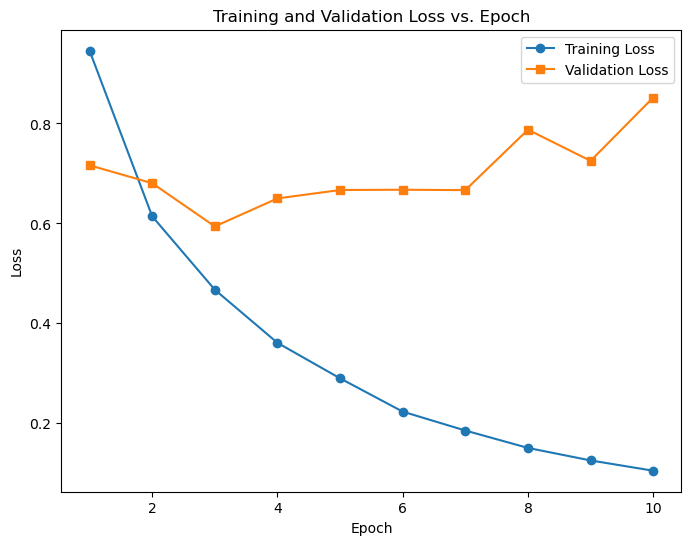

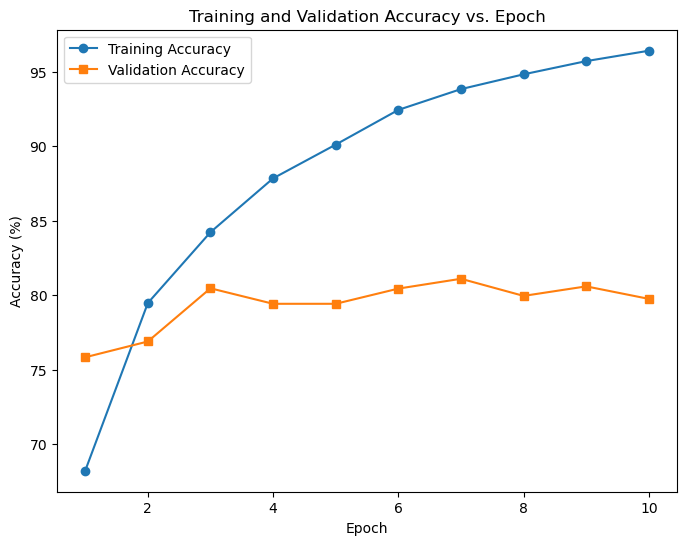

In [31]:
# Setup
model = resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train
train_losses = train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

### 1.1. FGSM

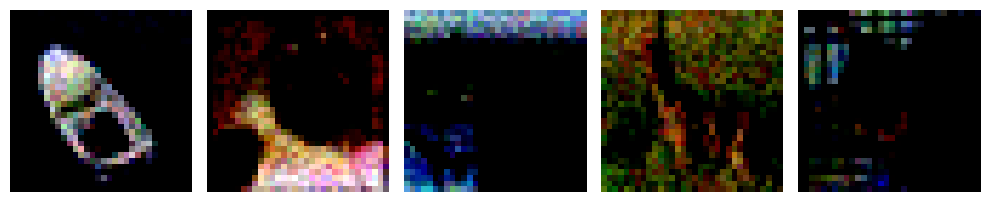

In [32]:
model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

# Display some adversarial images
num_images = 5
indices = np.random.choice(len(adversarial_images), num_images, replace=False)
plt.figure(figsize=(10, 4))
for i, index in enumerate(indices):
    plt.subplot(1, num_images, i+1)
    plt.imshow(np.transpose(adversarial_images[index], (1, 2, 0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

### 1.2. Test original data/Cross entropy

Accuracy on original test data: 78.78%


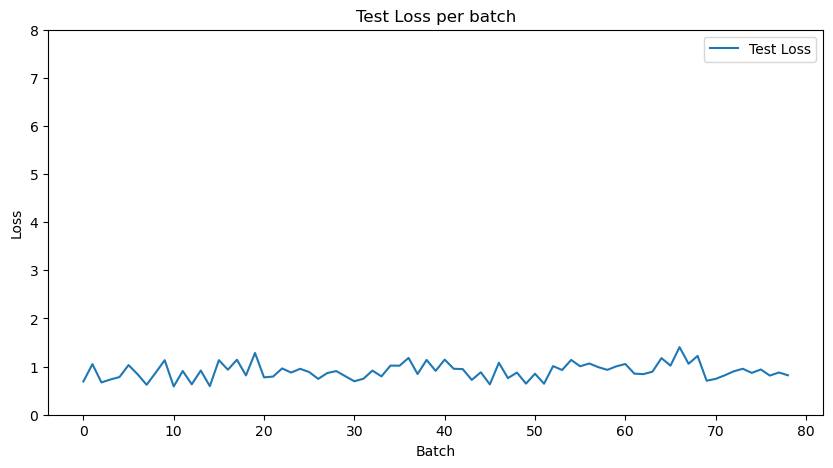

Accuracy on adversarial test data: 9.13%


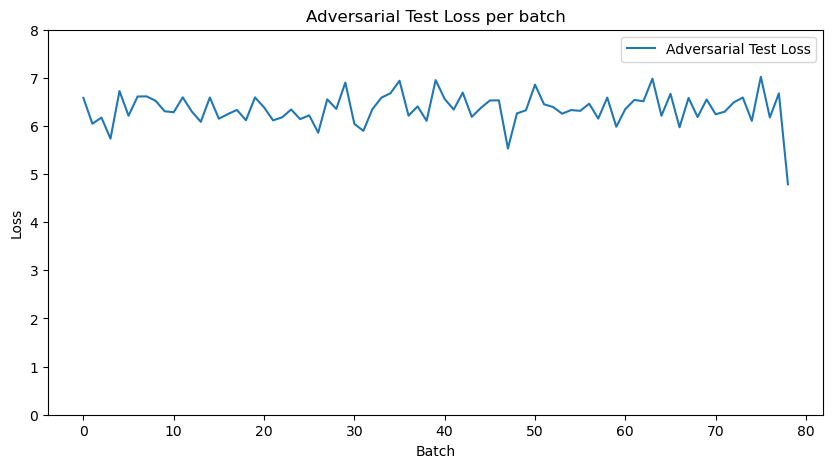

In [33]:
# Test the model on original test data
test_model(model, test_loader, criterion, device)

# Test the model on adversarial test data
test_model_adversarial(model, adversarial_images, labels, criterion, device)

In [11]:
train_features, train_labels = extract_features(model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(model, knn_classifier, test_loader)
test_model_adversarial_knn(model, knn_classifier, adversarial_images, labels, device)

AssertionError: Torch not compiled with CUDA enabled

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


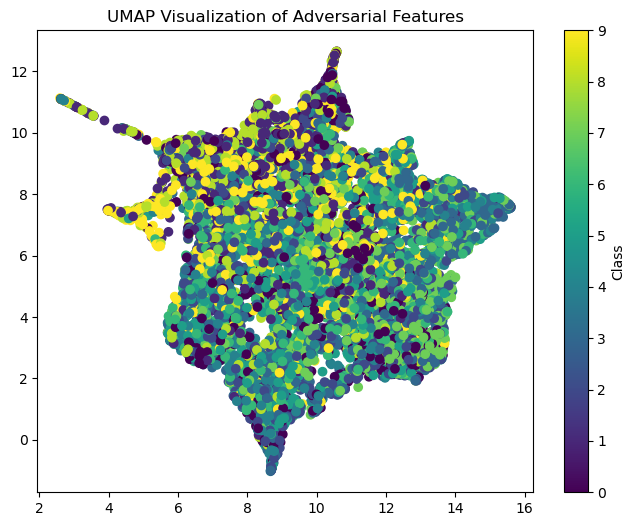

In [13]:
# Call the function to extract and visualize features
extract_and_visualize_features(model, adversarial_images, labels, device)

# 2. Train on agumented data/Cross entropy

In [14]:
# Function to apply FGSM attack with 50% probability to each batch
def apply_fgsm(model, images, labels, criterion, eps):
    # Enable gradients for images
    images.requires_grad = True

    # Perform FGSM attack only if gradients are enabled
    if images.requires_grad:
        outputs = model(images)
        model.zero_grad()
        cost = criterion(outputs, labels)
        cost.backward()
        attack_images = images + eps * images.grad.sign()
        attack_images = torch.clamp(attack_images, 0, 1)
    else:
        attack_images = images

    return attack_images

# Modified training function to apply FGSM with 50% probability
def train_with_fgsm(model, train_loader, val_loader, criterion, optimizer, device, epochs, eps=0.1):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0.0
        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Apply FGSM attack with 50% probability
            if torch.rand(1) < 0.5:
                images = apply_fgsm(model, images, labels, criterion, eps)

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_epoch_loss += loss.item()
        train_epoch_loss /= len(train_loader)
        train_losses.append(train_epoch_loss)

        # Validation loop
        model.eval()
        val_epoch_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Note: No FGSM attack is applied during validation
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_epoch_loss += loss.item()
        val_epoch_loss /= len(val_loader)
        val_losses.append(val_epoch_loss)

        # Print training and validation loss
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {train_epoch_loss:.4f}, Validation Loss: {val_epoch_loss:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, 'o-', label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, 's-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss vs. Epoch')
    plt.legend()
    plt.show()

    return train_losses, val_losses

/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Training Loss: 1.4733, Validation Loss: 0.9566
Epoch [2/10], Training Loss: 1.1809, Validation Loss: 0.8392
Epoch [3/10], Training Loss: 1.0436, Validation Loss: 0.7904
Epoch [4/10], Training Loss: 0.9486, Validation Loss: 0.6775
Epoch [5/10], Training Loss: 0.7619, Validation Loss: 0.6288
Epoch [6/10], Training Loss: 0.7952, Validation Loss: 0.7518
Epoch [7/10], Training Loss: 0.7189, Validation Loss: 0.6206
Epoch [8/10], Training Loss: 0.6633, Validation Loss: 0.6825
Epoch [9/10], Training Loss: 0.6231, Validation Loss: 0.6476
Epoch [10/10], Training Loss: 0.5976, Validation Loss: 0.6494


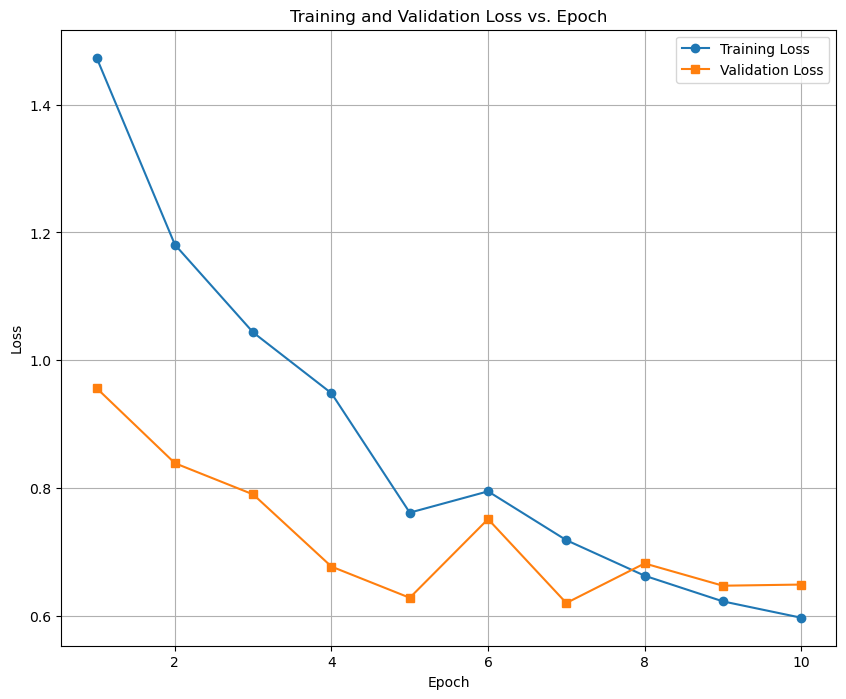

In [15]:
# Setup and Retrain
new_model = resnet18(pretrained=True)
num_features = new_model.fc.in_features
new_model.fc = nn.Linear(num_features, 10)
new_model = new_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.parameters(), lr=0.001)

# Train
train_losses = train_with_fgsm(new_model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

### 2.1. FGSM

In [16]:
model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

### 2.2. Test agumented data/Cross entropy

Accuracy on original test data: 76.95%


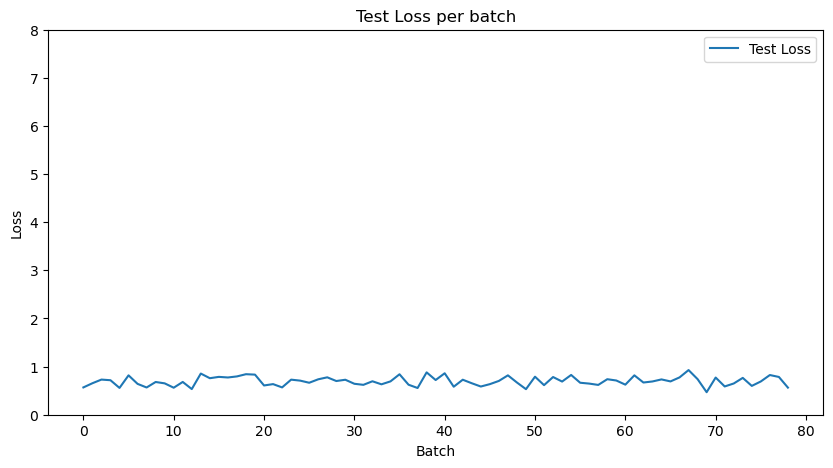

Accuracy on adversarial test data: 37.70%


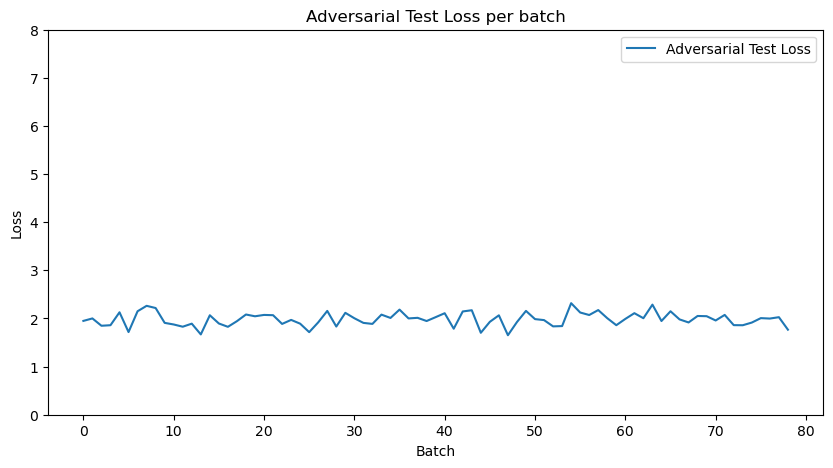

In [17]:
# Test the new model on original test data
test_model(new_model, test_loader, criterion, device)

# Test the new model on adversarial test data
test_model_adversarial(new_model, adversarial_images, labels, criterion, device)

In [18]:
# KNN test
train_features, train_labels = extract_features(new_model, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)

test_model_knn(new_model, knn_classifier, test_loader)
test_model_adversarial_knn(new_model, knn_classifier, adversarial_images, labels, device)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# Call the function to extract and visualize features
extract_and_visualize_features(new_model, adversarial_images, labels, device)

# 3. Train on original data/Circle loss

In [51]:
# Setup and Retrain
new_model2 = resnet18(pretrained=True)
num_features = new_model2.fc.in_features
new_model2.fc = nn.Linear(num_features, 10)
new_model2 = new_model2.to(device)

criterion = losses.CircleLoss(m=0.7, gamma=32)
optimizer = optim.Adam(new_model2.parameters(), lr=0.001)

# Train
train_losses_circle = train(new_model2, train_loader, val_loader, criterion, optimizer, device, num_epochs)

Epoch [1/10], Training Loss: 2.8876, Training Accuracy: 6.00%, Validation Loss: 2.1246, Validation Accuracy: 4.24%
Epoch [2/10], Training Loss: 1.5095, Training Accuracy: 4.38%, Validation Loss: 1.5838, Validation Accuracy: 5.71%


KeyboardInterrupt: 

### 3.1. FGSM

In [36]:
model.eval()
adversarial_images = []
original_images = []
labels = []

for images, targets in val_loader:
    images, targets = images.to(device), targets.to(device)
    images_with_attack = combine_fgsm_and_noise(model, images, targets, eps, noise_factor).detach().cpu().numpy()
    adversarial_images.append(images_with_attack)
    original_images.append(images.detach().cpu().numpy())
    labels.append(targets.detach().cpu().numpy())

# Convert lists to numpy arrays
adversarial_images = np.concatenate(adversarial_images)
original_images = np.concatenate(original_images)
labels = np.concatenate(labels)

### 3.2. Test agumented data/Cross entropy

Accuracy on original test data: 7.75%


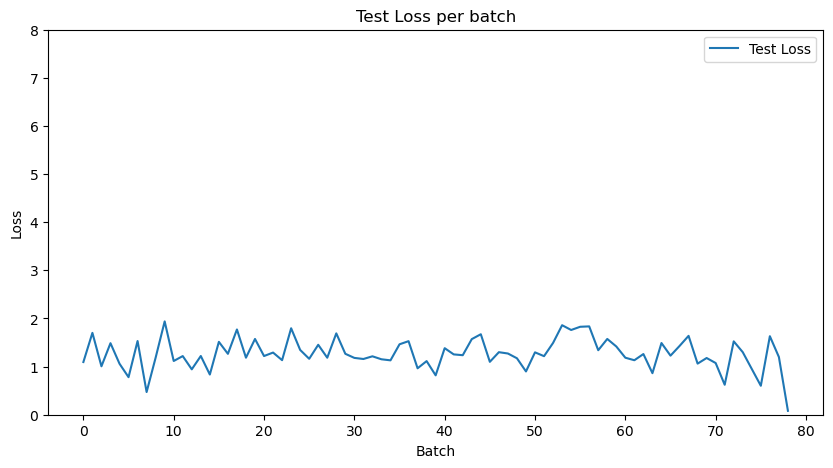

Accuracy on adversarial test data: 8.99%


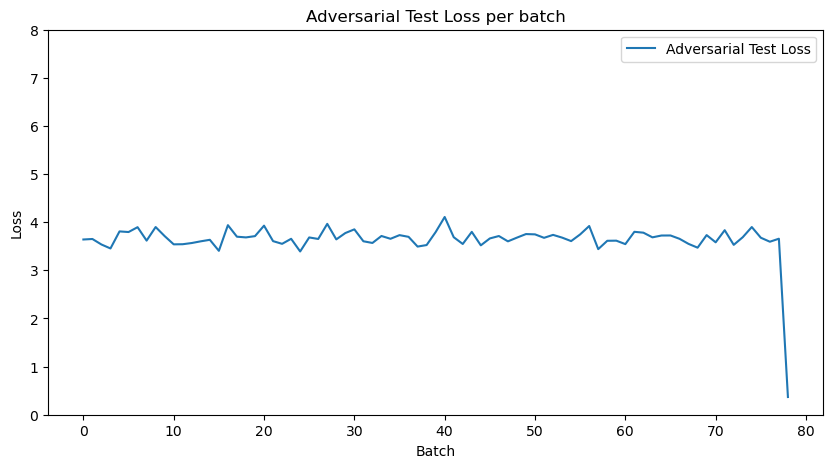

In [37]:
# Test the new model on original test data
test_model(new_model2, test_loader, criterion, device)

# Test the new model on adversarial test data
test_model_adversarial(new_model2, adversarial_images, labels, criterion, device)

In [38]:
# KNN test
train_features, train_labels = extract_features(new_model2, train_loader)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, train_labels)


test_model_knn(new_model2, knn_classifier, test_loader)
test_model_adversarial_knn(new_model2, knn_classifier, adversarial_images, labels, device)

AssertionError: Torch not compiled with CUDA enabled